In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import types

In [3]:

###################################################      计算、判断函数        #####################################################################   

def IN_OR_OUT(highArray,lowArray,price,T):
    up = max(highArray[-T-1:-1])
    down = min(lowArray[-T-1:-1])  
    #print 'up:',up,'down:',down，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
    if price>up:
        return 1
    elif price<down:
        return -1
    else:
        return 0 

def CalcATR(highArray,lowArray,closeArray,T):
    TR_List = []
    for i in range(1,T+1):
        TR = max(highArray[i]-lowArray[i],highArray[i]-closeArray[i-1],
                 closeArray[i-1]-lowArray[i])
        TR_List.append(TR)
    ATR = np.array(TR_List).mean()
    return ATR

def Add_OR_Stop(price,lastprice,ATR,position_state,inRate):# 加仓或止损
    if (price >= lastprice + inRate*ATR and position_state==1) or (price <= lastprice - inRate*ATR and position_state==-1): # 多头加仓或空头加仓
        return 1
    elif (price <= lastprice - 2*ATR and position_state==1) or (price >= lastprice + 2*ATR and position_state==-1):  # 多头止损或空头止损
        return -1
    else:
        return 0
    
def sumpnl(priceArr,ordercnt,price,position_state,Turprice_perpoint,commission,slip):
    pnl = 0
    for i in range(len(priceArr)):
        delta= (price - priceArr[i])*position_state*ordercnt[i]*Turprice_perpoint
        fee =  price*Turprice_perpoint*ordercnt[i]*commission + ordercnt[i]*Turprice_perpoint*slip #手续费和滑点费用
        delta -= fee
        pnl += delta
    return pnl
def CalcUnit(cash,ATR,coef):  # coef 为 x 吨/手
    if ATR < 6:
        return 0
    x = (cash*0.01/ATR)/coef
    
    return int(x)
def Sharp(pnlArr,cash0):
    rf = 0.04
    n = len(pnlArr)
    r = []
    for i in range(0,n):
        if i == 0:
            r.append(pnlArr[i]/cash0-1)
            #print pnlArr[i]/cash0-1
        else:
            r.append(pnlArr[i]/pnlArr[i-1]-1)
            #print pnlArr[i]/pnlArr[i-1]-1
    Ex = np.mean(r)
    stdev = np.std(r)
    SharpRatio = (Ex*n-rf)/(stdev*np.sqrt(n))
    return SharpRatio
    

In [4]:
#########每一组参数下计算的夏普比率值######################
#T 唐安琪通道
#inRate 加仓ATR前面的系数
#highPrice,lowPrice,closePrice 价格序列
def ParaSharp(T,inRate,highPrice,lowPrice,closePrice):
    
    #---------------------------------海龟策略参数
    # 获取数据
    cash = 20000
    unit = 0
    coef = 10
    #inRate = 0.5             #加仓ATR的比例
    #T = 10                   #唐奇安通道中的N
    Turlast_deal_prcie = 0    #上一次交易价
    Turlimit_unit = 4         # 限制最多买入的单元数
    Turadd_time = 0           # 加仓次数
    Turposition_state = 0     #持仓状态，0为未持仓，1位持多，-1为持空
    Turprice_perpoint = 10    #合约每点价格
    Turtrade_cnt = 0          #交易次数
    sec = 0.12                #保证金比率
    commission = 0.0001       #手续费
    slip = 1                  #滑点
    sec_money = 0             #合约一手保证金
    sec_all = 0               #总保证金
    data_len = len(closePrice)
    priceArr = []
    ordercnt = []
    cashArr = []
    maxPrice = 0
    minPrice = 0

    for i in range(0,data_len-T):
    #############################################      海龟策略主体     ########################################### 
        highArray = highPrice[i:i+T+1]
        lowArray = lowPrice[i:i+T+1]
        closeArray = closePrice[i:i+T+1]
        prices = closeArray[-1] # 交易价格
   
        #止损止盈退场
        if Turposition_state != 0:
            minPrice = min(minPrice,lowPrice[i+T])
            maxPrice = max(maxPrice,highPrice[i+T])
            if -(prices-maxPrice)*Turposition_state > maxPrice*0.02 and Turposition_state == 1:
                Turtrade_cnt += 1
                cash += sec_all
                sec_all = 0
                cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
                cashArr.append(cash)
                Turposition_state = 0
                priceArr = []
                ordercnt = []
                continue
            if -(prices-minPrice)*Turposition_state > minPrice*0.02 and Turposition_state == -1:
                Turtrade_cnt += 1
                cash += sec_all
                sec_all = 0
                cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
                cashArr.append(cash)
                Turposition_state = 0
                priceArr = []
                ordercnt = []
                continue
            
        # 1 计算ATR
        ATR = CalcATR(highArray,lowArray,closeArray,T)
        # 2 判断加仓或止损
        if Turposition_state!= 0 :   # 先判断是否持仓
            temp = Add_OR_Stop(prices,Turlast_deal_prcie,ATR,Turposition_state,inRate)
            if temp ==1 and Turadd_time < Turlimit_unit:  # 加仓
                if Turposition_state == 1: # 多头加仓
                    unit = CalcUnit(cash,ATR,coef)
                    if unit == 0:
                        continue
                    sec_money = prices*sec*Turprice_perpoint*unit
                    fee =  prices*Turprice_perpoint*unit*commission + unit*Turprice_perpoint*slip #手续费和滑点费用
                    sec_all += sec_money
                    cash -= sec_money
                    cash -= fee
                    Turlast_deal_prcie = prices
                    priceArr.append(prices)
                    ordercnt.append(unit)
                    Turadd_time += 1
                    Turtrade_cnt += 1
                    #print sum(ordercnt)
                if Turposition_state == -1: # 空头加仓
                    unit = CalcUnit(cash,ATR,coef)
                    if unit == 0:
                        continue
                    sec_money = prices*sec*Turprice_perpoint*unit
                    fee =  prices*Turprice_perpoint*unit*commission + unit*Turprice_perpoint*slip #手续费和滑点费用
                    sec_all += sec_money
                    cash -= sec_money
                    cash -= fee
                    Turlast_deal_prcie = prices
                    priceArr.append(prices)
                    ordercnt.append(unit)
                    Turadd_time += 1
                    Turtrade_cnt += 1
                    #print sum(ordercnt)
            elif temp== -1:      # 止损  
                Turtrade_cnt += 1
                if Turposition_state == 1: # 多头平仓
                    cash += sec_all
                    sec_all = 0
                    cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
                    cashArr.append(cash)
                    Turposition_state = 0
                    priceArr = []
                    ordercnt = []
                
                else:  # 空头平仓
                    cash += sec_all
                    sec_all = 0
                    cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
                    cashArr.append(cash)
                    Turposition_state = 0
                    priceArr = []
                    ordercnt = []
            
        #3  多开空开(空平多平)
        out = IN_OR_OUT(highArray,lowArray,prices,T)
        if out ==1 and Turposition_state !=1:  #多开(空平)
            # 先看是否需要空头平仓
            if Turposition_state == -1:
                cash += sec_all
                sec_all = 0
                cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
                cashArr.append(cash)
                Turposition_state = 0
                priceArr = []
                ordercnt = []
                Turtrade_cnt += 1
            # 多开
            elif Turposition_state == 0:
                unit = CalcUnit(cash,ATR,coef)
                if unit == 0:
                    continue
                sec_money = prices*sec*Turprice_perpoint*unit
                fee =  prices*Turprice_perpoint*unit*commission + unit*Turprice_perpoint*slip #手续费和滑点费用
                sec_all += sec_money
                cash -= sec_money
                cash -= fee
                Turposition_state = 1  # 更新持仓状态为持多
                Turadd_time = 1
                Turlast_deal_prcie = prices
                priceArr.append(prices)
                ordercnt.append(unit)
                maxPrice = highPrice[i+T]
                Turtrade_cnt += 1
        elif out==-1 and Turposition_state != -1: #空开（多平）
            # 先看是否需要多头平仓
            if Turposition_state == 1:
                cash += sec_all
                cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
                cashArr.append(cash)
                sec_all = 0
                Turposition_state = 0
                priceArr = []
                ordercnt = []
                Turtrade_cnt += 1
            # 空开
            elif Turposition_state == 0:
                unit = CalcUnit(cash,ATR,coef)
                if unit == 0:
                    continue
                sec_money = prices*sec*Turprice_perpoint*unit
                fee =  prices*Turprice_perpoint*unit*commission + unit*Turprice_perpoint*slip #手续费和滑点费用
                sec_all += sec_money
                cash -= sec_money
                cash -= fee
                Turposition_state = -1   #更新持仓状态为持空
                Turadd_time = 1
                Turlast_deal_prcie = prices
                priceArr.append(prices)
                ordercnt.append(unit)
                minPrice = lowPrice[i+T]
                Turtrade_cnt += 1

    if Turposition_state != 0:
        cash += sec_all
        cash += sumpnl(priceArr,ordercnt,prices,Turposition_state,Turprice_perpoint,commission,slip)
        cashArr.append(cash)
        Turtrade_cnt += 1
        #TurpnlArr.append(float(Turpnl))
    

    #########################################################################################################    
    SharpRatio = Sharp(cashArr,cash)
    return SharpRatio



In [7]:
#从csv中读取螺纹钢10min数据 包括time close high low
RBdata = pd.read_csv('data.csv')
datetimeData = np.array(RBdata['datetimeData'])
datetimeData = datetimeData.tolist()
closePrice = np.array(RBdata['closePrice'])
closePrice = closePrice.tolist()
highPrice = np.array(RBdata['highPrice'])
highPrice = highPrice.tolist()
lowPrice = np.array(RBdata['lowPrice'])
lowPrice = lowPrice.tolist()

In [13]:
T_List = np.linspace(3,30,28,dtype='int')
inRate_List = np.linspace(0.1,1.5,20,dtype='float')
Sharp_List = []
for i in T_List:
    for k in inRate_List:
        s = ParaSharp(i,k,highPrice,lowPrice,closePrice)
        #print s
        Sharp_List.append(s)

In [89]:
##保存夏普比率
SharpDF = pd.DataFrame(Sharp_List)
SharpDF.to_excel('Sharp.xlsx')

In [43]:
#######分析夏普比率##############
SharpArr = pd.read_excel('Sharp.xlsx')
SharpArr = np.array(SharpArr['Sharp'])
SharpArr = SharpArr.tolist()

In [91]:
#sharpe的值
z = np.array([[0]*28]*20,dtype='float')
m = 28
n = 20
for i in range(m):
    for k in range(n):
        z[k][i] = Sharp_List[i*n+k]

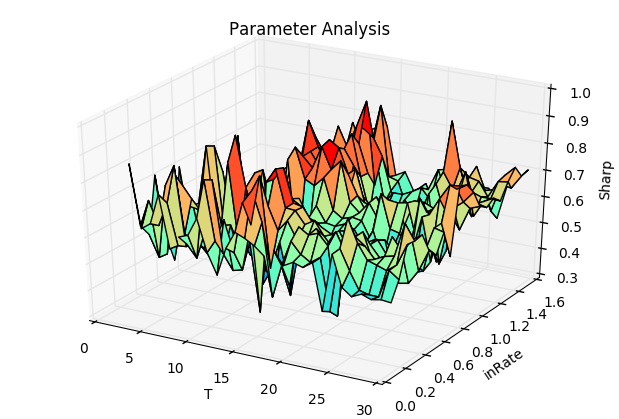

In [92]:
##参数敏感性分析图###########
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

figure = plt.figure()
ax = Axes3D(figure)
plt.title('Parameter Analysis')
X = np.linspace(3,30,28,dtype='int')
Y = np.linspace(0.1,1.5,20,dtype='float')
ax.set_xlabel('T')
ax.set_ylabel('inRate')
ax.set_zlabel('Sharp')
#网格化数据
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, z, rstride=1, cstride=1, cmap='rainbow')


plt.show()